In [0]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import cv2
from sklearn.preprocessing import normalize
import skimage.morphology as morp
from skimage.filters import rank
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)

Using TensorFlow backend.


2.2.4
1.13.1


##Load the Data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

train = pickle.load(open("gdrive/My Drive/ML/train.p", "rb"))
valid = pickle.load(open("gdrive/My Drive/ML/valid.p", "rb"))
test = pickle.load(open("gdrive/My Drive/ML/test.p", "rb"))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Dataset Summary

In [0]:
# Number training examples.
print("Number training examples =", len(train["labels"]))
# Number of testing examples.
print("Number testing examples =", len(test["labels"]))
# Number of validation examples. 
print("Number validation examples =", len(valid["labels"]))
# Number of classes.
classes = list(set(train["labels"]))
print("Number of classes =", len(classes))

Number training examples = 34799
Number testing examples = 12630
Number validation examples = 4410
Number of classes = 43


## Plot Sample Images

1800


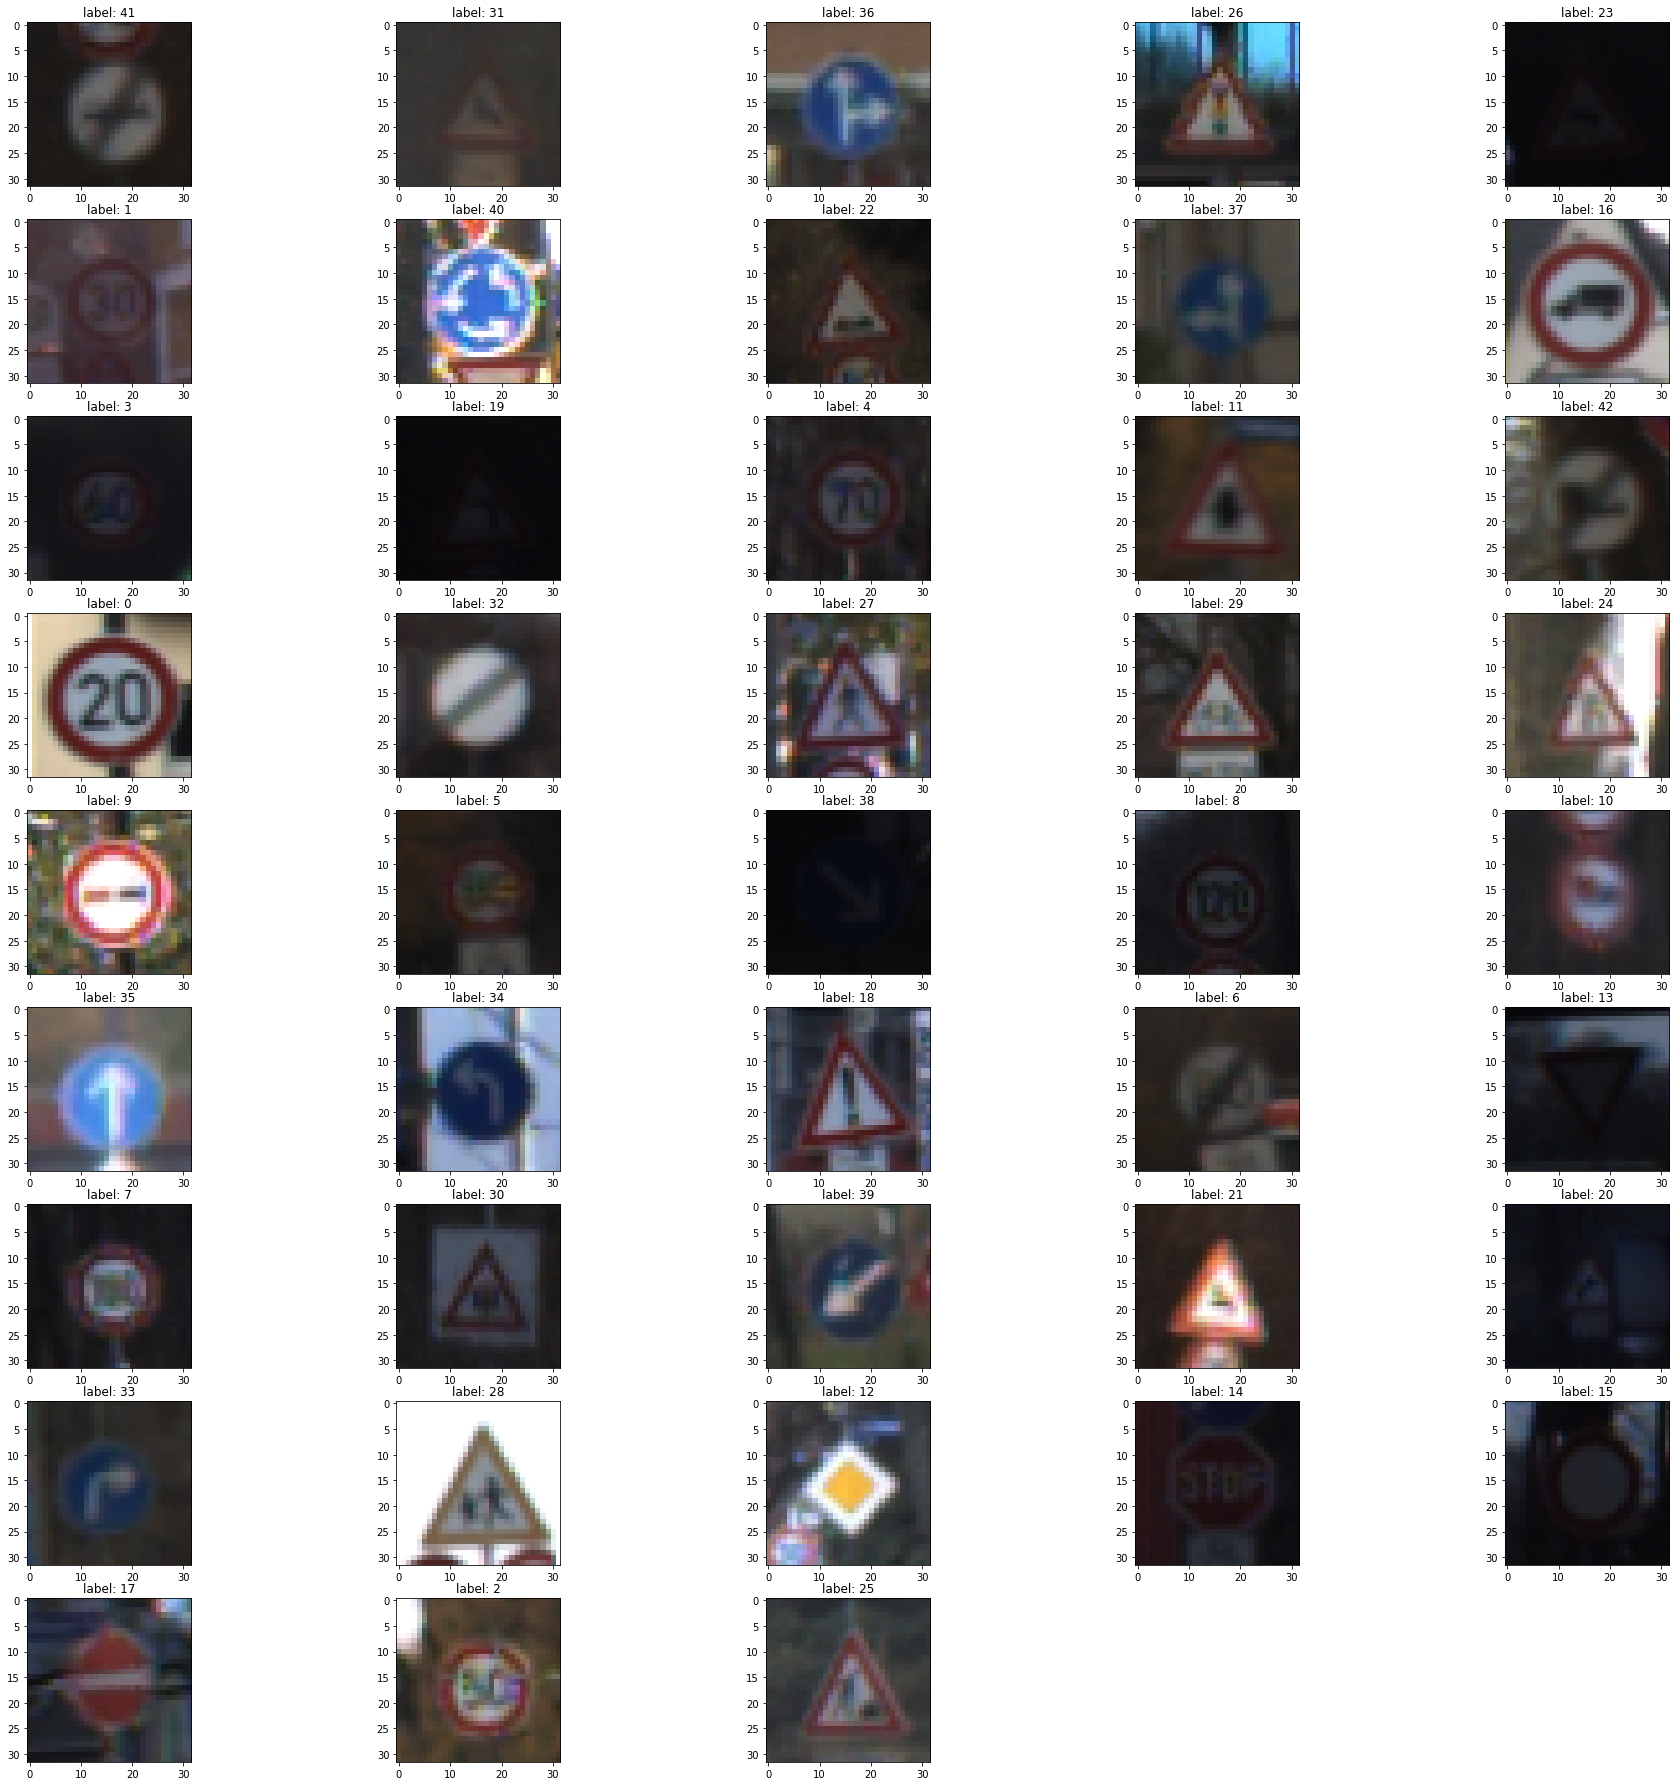

In [0]:
train_features = train["features"]
train_labels = train["labels"]
valid_features = valid["features"]
valid_labels = valid["labels"]
test_features = test["features"]
test_labels = test["labels"]

flags = [0]*len(classes)
plt.figure(figsize=(32,32))
j = 1
c = 0
for i in range(len(train_labels)):
    if not(flags[train_labels[i]]):
        plt.subplot(9,5,j)
        plt.imshow(train_features[i])
        plt.title("label: "+str(train_labels[i]))
        j += 1
        flags[train_labels[i]] = 1
    if train_labels[i] == 10:
        c += 1
print(c)

## Histogram

(array([ 180., 1980., 2010., 1260., 1770., 1650.,  360., 1290., 1260.,
        1320., 1800., 1170., 1890., 1920.,  690.,  540.,  360.,  990.,
        1080.,  180.,  300.,  270.,  330.,  450.,  240., 1350.,  540.,
         210.,  480.,  240.,  390.,  690.,  210.,  599.,  360., 1080.,
         330.,  180., 1860.,  270.,  300.,  210.,  210.]),
 array([ 0.        ,  0.97674419,  1.95348837,  2.93023256,  3.90697674,
         4.88372093,  5.86046512,  6.8372093 ,  7.81395349,  8.79069767,
         9.76744186, 10.74418605, 11.72093023, 12.69767442, 13.6744186 ,
        14.65116279, 15.62790698, 16.60465116, 17.58139535, 18.55813953,
        19.53488372, 20.51162791, 21.48837209, 22.46511628, 23.44186047,
        24.41860465, 25.39534884, 26.37209302, 27.34883721, 28.3255814 ,
        29.30232558, 30.27906977, 31.25581395, 32.23255814, 33.20930233,
        34.18604651, 35.1627907 , 36.13953488, 37.11627907, 38.09302326,
        39.06976744, 40.04651163, 41.02325581, 42.        ]),
 <a list of

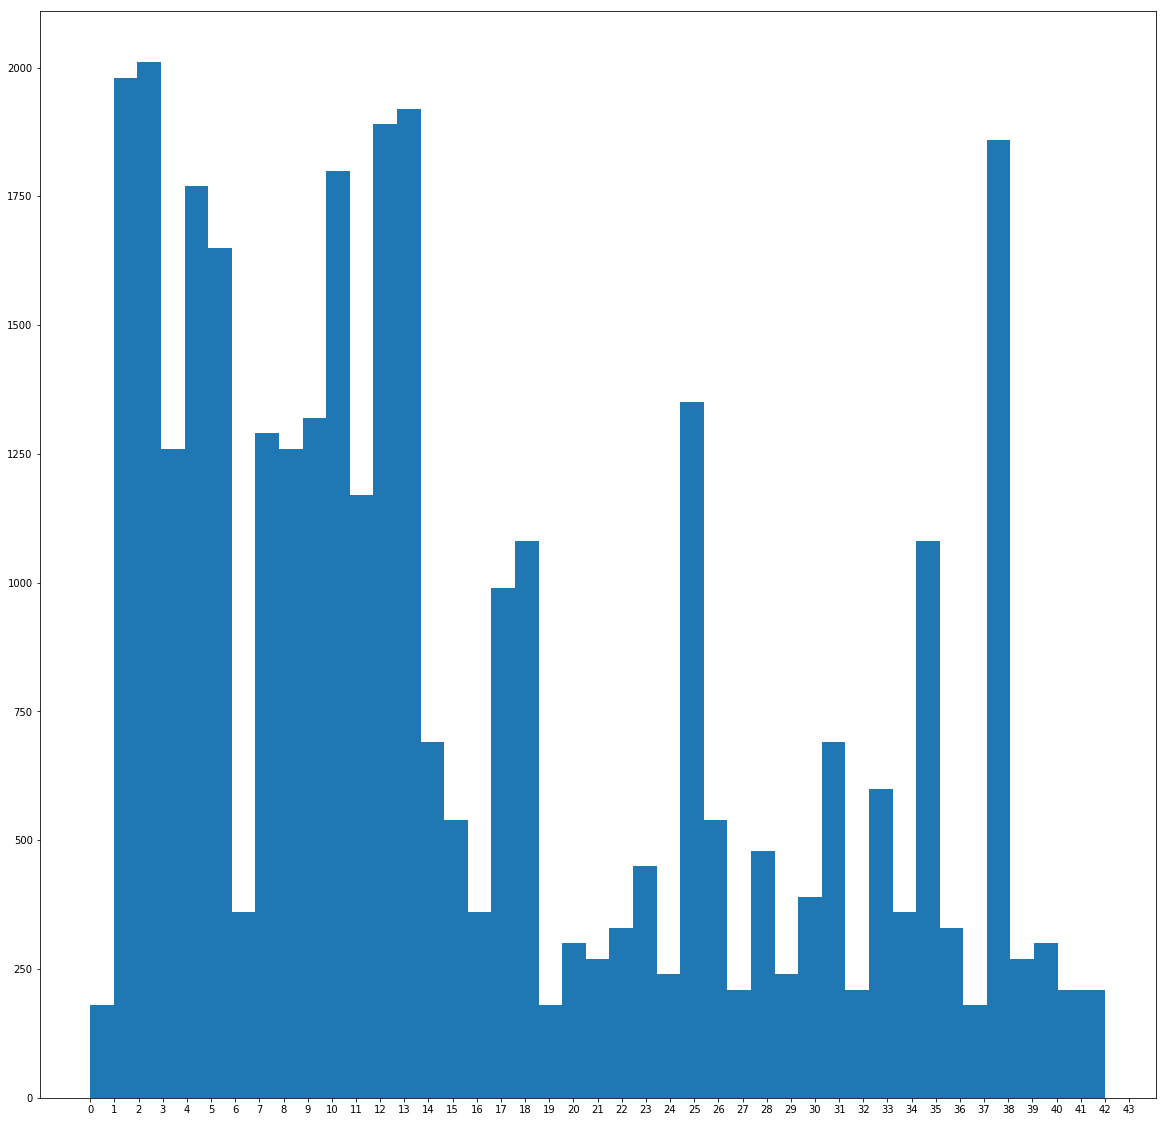

In [0]:
xticks = [i for i in range(len(classes)+1)]
plt.figure(figsize=(20,20))
plt.xticks(xticks)
plt.hist(train_labels, bins=43)

## Data Preprocessing

In [0]:
# shuffling
X_train, y_train = shuffle(train_features, train_labels)
X_valid, y_valid = shuffle(valid_features, valid_labels)
X_test, y_test = shuffle(test_features, test_labels)

# grayscaling
X_train_grayscale = []
for i in range(len(X_train)):
    X_train_grayscale.append(cv2.cvtColor(X_train[i], cv2.COLOR_RGB2GRAY))
X_train = X_train_grayscale

X_valid_grayscale = []
for i in range(len(X_valid)):
    X_valid_grayscale.append(cv2.cvtColor(X_valid[i], cv2.COLOR_RGB2GRAY))
X_valid = X_valid_grayscale

X_test_grayscale = []
for i in range(len(X_test)):
    X_test_grayscale.append(cv2.cvtColor(X_test[i], cv2.COLOR_RGB2GRAY))
X_test = X_test_grayscale


In [0]:
def local_histogram_equalization(img):
    kernel = morp.disk(30)
    return rank.equalize(img, selem=kernel)
def normalization(img):
    return normalize(img)

In [0]:
X_train = np.array(list(map(local_histogram_equalization, X_train)))
X_valid = np.array(list(map(local_histogram_equalization, X_valid)))
X_test = np.array(list(map(local_histogram_equalization, X_test)))

X_train = np.array(list(map(normalization, X_train)))
X_valid = np.array(list(map(normalization, X_valid)))
X_test = np.array(list(map(normalization, X_test)))

In [0]:
y_train = keras.utils.to_categorical(y_train, len(classes))
y_test = keras.utils.to_categorical(y_test, len(classes))
y_valid = keras.utils.to_categorical(y_valid, len(classes))

X_train = X_train.reshape([-1,32, 32,1])
X_valid = X_valid.reshape([-1,32, 32,1])
X_test = X_test.reshape([-1,32, 32,1])

## Network Architecture

In [0]:
def createModel():
    model = Sequential() 
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,1)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(classes)))
    model.add(Activation('softmax'))
    
    return model

## Training and Testing

In [0]:
batch_size = 64
epochs = 15

model = createModel()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_valid, y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/15
34799/34799 [==============================] - 20s 580us/step - loss: 3.2240 - acc: 0.1162 - val_loss: 1.7639 - val_acc: 0.4769
Epoch 2/15
34799/34799 [==============================] - 16s 460us/step - loss: 1.3042 - acc: 0.5800 - val_loss: 0.6851 - val_acc: 0.7723
Epoch 3/15
34799/34799 [==============================] - 15s 428us/step - loss: 0.7238 - acc: 0.7570 - val_loss: 0.4126 - val_acc: 0.8583
Epoch 4/15
34799/34799 [==============================] - 15s 433us/step - loss: 0.4827 - acc: 0.8443 - val_loss: 0.2843 - val_acc: 0.9190
Epoch 5/15
34799/34799 [==============================] - 15s 434us/step - loss: 0.3476 - acc: 0.8904 - val_loss: 0.1532 - val_acc: 0.9528
Epoch 6/15
34799/34799 [==============================] - 15s 434us/step - loss: 0.2561 - acc: 0.9230 - val_loss: 0.1042 - val_acc: 0.9671
Epoch 7/15
34799/34799 [==============================] - 15s 435us/step - loss: 0.2213 - acc: 0.9331 - val_loss: 0.1

In [0]:
acc = model.evaluate(X_test, y_test)
print("Testing Accuracy:", acc[1]*100,"%")

12630/12630 [==============================] - 2s 148us/step
Testing Accuracy: 95.19398258115598 %


## Visulaize the Results 

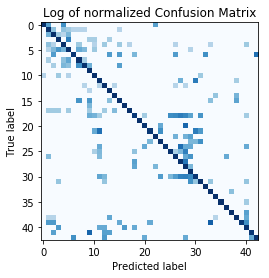

In [0]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_labeled = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_labeled, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

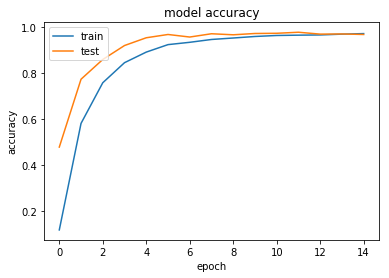

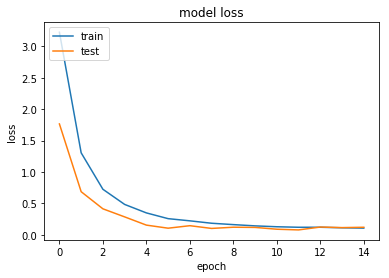

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()